# Dice Dissimilarity Calculation using Nipype

In this Jupyter notebook, we will be using the nipype library to calculate the Dice dissimilarity between two sets of neuroimaging volumes. The pipeline will also include a HistogramPlot interface to generate a .txt file of all Dice scores and a histogram plot in .png format. 

## Inputs
- Two directories containing neuroimaging volumes (source_dir, target_dir)

## Outputs
To be found in your specified "PATH_TO_OUTPUT_DIR" directory:
- Dice score of the two volumes
- .txt file of all Dice scores
- histogram plot in .png format

## Nipype Workflow
1. Iterate through each outputs from FSL BET, FAST, FLIRT, FIRST
2. Get all files from the two directories and check if they have the same list of subjects
3. Calculate the Dice dissimilarity from the curated files
4. Generate the .txt file of Dice scores and the histogram plot

To run the code on your local machine, please follow these steps:
1. Replace the string "PATH_TO_IMAGE_DIR1", "PATH_TO_IMAGE_DIR2" and "PATH_TO_OUTPUT_DIR" with the actual paths to the source and target directories and the working directory on your machine. 
2. Replace "PATH_TO_IMAGE_DIR1" and "PATH_TO_IMAGE_DIR2" with your suitable directories of images to compare.
3. Replace "PATH_TO_OUTPUT_DIR" with a new directory for outputs.
4. Run the code and wait for it to complete.
5. Once the code has completed running, the user can find the output files (the .txt file and .png plot) in the directory specified in "PATH_TO_OUTPUT_DIR".

## Install nilearn

In [ ]:
!pip install nilearn

## Import necessary packages

In [20]:
import os
import glob
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from textwrap import wrap

from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import DataSink
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.base import \
    BaseInterface, TraitedSpec, File, \
    traits, BaseInterfaceInputSpec, SimpleInterface, InputMultiPath

mean = 0.000146, standard deviation = 0.000072, range = 0.000058 - 0.000459, subjects = 157
mean = 0.000000343, standard deviation = 0.000002, range = 0.000000 - 0.000022, subjects = 157


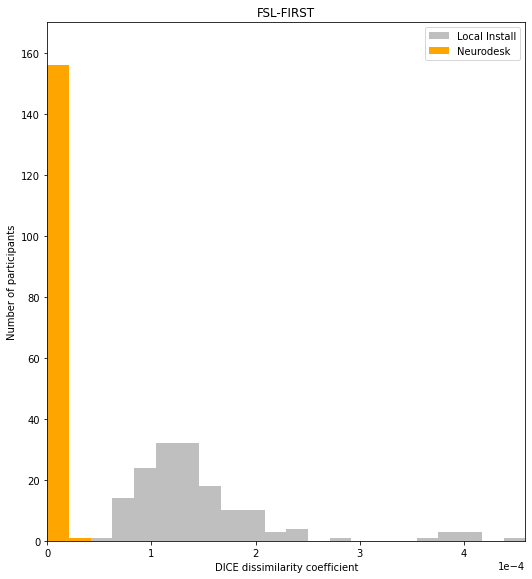

mean = 0.512577, standard deviation = 0.167260, range = 0.190425 - 0.900517, subjects = 157
mean = 0.000000000, standard deviation = 0.000000, range = 0.000000 - 0.000000, subjects = 157


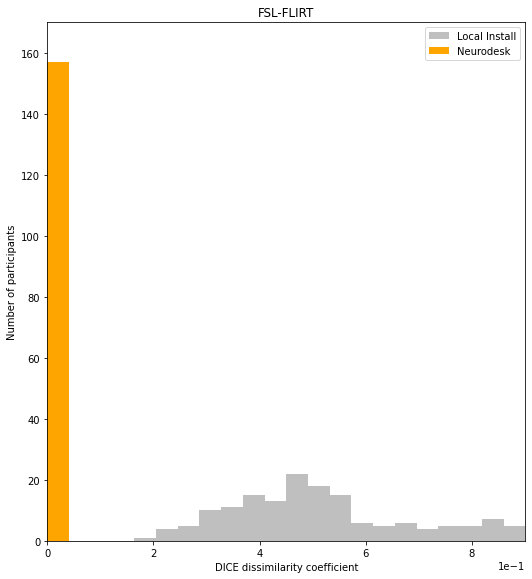

In [26]:
def plotHist(command):
    native = np.genfromtxt("./data/dice_score/dice_fsl_" + command + "_local.txt", delimiter='\n')
    neuro = np.genfromtxt("./data/dice_score/dice_fsl_" + command + "_neurodesk.txt", delimiter='\n')

    minval = min(np.min(native), np.min(neuro))
    maxval = max(np.max(native), np.max(neuro))

    print(''.join(f'mean = {np.mean(native):.6f}, standard deviation = {np.std(native):.6f}, range = {np.min(native):.6f} - {np.max(native):.6f}, subjects = {len(native)}'))
    print(''.join(f'mean = {np.mean(neuro):.9f}, standard deviation = {np.std(neuro):.6f}, range = {np.min(neuro):.6f} - {np.max(neuro):.6f}, subjects = {len(neuro)}'))
    F = plt.figure(figsize=(8.3,9), facecolor=(1, 1, 1))
    F.tight_layout()
            
    ax1 = F.add_axes([0.12, 0.12, 0.8, 0.8], xlim=(minval,maxval), ylim=(0,170)) 

    bins = np.histogram_bin_edges(native, bins=22, range=(minval, maxval))

    ax1.hist(native, bins=bins, alpha=0.5, color='grey', label='Local Install')
    ax1.hist(neuro, bins=bins, color='orange', label='Neurodesk')
    plt.legend(loc='upper right')
    ax1.set_title('FSL-'+ command.upper())
    ax1.set_xlabel('DICE dissimilarity coefficient')
    ax1.set_ylabel('Number of participants')

    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.show()

plotHist("flirt")
plotHist("first")

## Execute the workflow below if you have your own data to compare.

In [ ]:
class DiceDissimilarityInputSpec(BaseInterfaceInputSpec):
    volume1 = File(
        exists=True, mandatory=True, desc="Has to have the same dimensions as volume2."
    )
    volume2 = File(
        exists=True, mandatory=True, desc="Has to have the same dimensions as volume1."
    )


class DiceDissimilarityOutputSpec(TraitedSpec):
    dice = traits.Float(desc="dice dissimilarity")


class DiceDissimilarity(BaseInterface):
    input_spec = DiceDissimilarityInputSpec
    output_spec = DiceDissimilarityOutputSpec

    def _run_interface(self, runtime):
        nii1 = nb.load(self.inputs.volume1)
        data1 = np.asanyarray(nii1.dataobj).astype(int)
        data1[np.isnan(data1)] = 0
        
        nii2 = nb.load(self.inputs.volume2)
        data2 = np.asanyarray(nii2.dataobj).astype(int)
        data2[np.isnan(data2)] = 0
        
        dice_dissimilarity = 1-2*np.sum(data1==data2)/ (len(data1.flat) + len(data2.flat))

        self._dice = dice_dissimilarity
        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs["dice"] = self._dice
        return outputs

In [ ]:
def plotHist(nii_files):
    dice_array = []
    
    for in_nii_file in nii_files:
        dice_array.append(in_nii_file)

    arr_file = "array.txt"
    with open(arr_file, 'w+') as f:
        for line in dice_array:
            f.write(str(line) + "\n")
    mean = np.mean(dice_array)
    std = np.std(dice_array)
    minval = np.min(dice_array)
    maxval = np.max(dice_array)

    F = plt.figure(figsize=(8.3,9), facecolor=(1,1,1))
    F.tight_layout()
            
    ax1 = F.add_axes([0.12, 0.12, 0.8, 0.8], xlim=(np.min(dice_array), np.max(dice_array)), ylim=(0,170))           
    bin_edges = np.histogram_bin_edges(dice_array, bins='fd', range=(np.min(dice_array), np.max(dice_array)))
    ax1.hist(dice_array, bins=bin_edges)
    ax1.set_title('\n'.join(wrap(f'mean = {mean:.6f}, standard deviation = {std:.6f}, range = {minval:.6f} - {maxval:.6f}, subjects = {len(dice_array)}')))
    ax1.set_xlabel('DICE coefficient')
    ax1.set_ylabel('Number of occurences')
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.5f'))
    
    file_png = "plot.png"
    F.savefig(file_png,format='png')
    plt.clf()
    plt.close()
    del F
    return file_png, arr_file

class HistogramPlotInputSpec(TraitedSpec):
    in_files = InputMultiPath(
        exists=True, mandatory=True
    )

class HistogramPlotOutputSpec(TraitedSpec):
    plot = File(exists=True)
    arr = File(exists=True)

class HistogramPlot(BaseInterface):
    input_spec = HistogramPlotInputSpec
    output_spec = HistogramPlotOutputSpec
    
    def _run_interface(self, runtime):
        self._plot, self._arr = plotHist(self.inputs.in_files)
        
        runtime.returncode=0
        return runtime
    
    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs["plot"] = os.path.abspath(self._plot)
        outputs["arr"] = os.path.abspath(self._arr)
        return outputs

In [ ]:
def init_pattern_workflow(source_dir, target_dir, work_dir):
    patterns = ['brain.nii.gz', 'brain_seg.nii.gz', 'to_std_sub.nii.gz', 'all_fast_firstseg.nii.gz']
    wf = Workflow("workflow_pattern", base_dir=work_dir)
    wf.add_nodes([
        node for node in
        [init_subject_workflow(source_dir, target_dir, work_dir, pattern) for pattern in patterns]
        if node
    ])
    return wf


def init_subject_workflow(source_dir, target_dir, work_dir,pattern):
    wf = Workflow(pattern.replace('.nii.gz', ''), base_dir=os.path.join(work_dir, "workflow_pattern"))
    source_images = sorted(glob.glob(os.path.join(source_dir,  '*' + pattern)))
    source_subjects = sorted(list(set([os.path.split(path)[1] for path in source_images])))

    target_images = sorted(glob.glob(os.path.join(target_dir, '*' + pattern)))
    target_subjects = sorted(list(set([os.path.split(path)[1] for path in target_images])))

    # Double check if both directories have the same subjects
    source_path = sorted(
        os.path.join(os.path.dirname(image), subject)
        for image, subject in zip(source_images, source_subjects)
        if subject in target_subjects
    )
    target_path  = sorted(
        os.path.join(os.path.dirname(image), subject)
        for image, subject in zip(target_images, target_subjects)
        if subject in source_subjects
    )


    if not (target_path or source_path):
        print(f"No subjects found in: {os.path.join(target_dir, '*', pattern)} or {os.path.join(source_dir,'*', pattern)}")
        exit()

    source_target = Node(interface=IdentityInterface(fields=['source', 'target']),
                                                    name = 'source_target')                                               
    source_target.inputs.source = source_path
    source_target.inputs.target = target_path
    source_target.inputs.sort_filelist = True

    n_datasink = Node(
        interface=DataSink(
            base_directory=os.path.join(work_dir, pattern.replace('.nii.gz', ''))
        ),
        name='nipype_datasink'
    )

    Dice_dissimilarity = MapNode(interface=DiceDissimilarity(), 
                        name="dice_dissimilarity", 
                        iterfield=['volume1', 'volume2']
                    )

    plot_histogram = Node(interface=HistogramPlot(), 
                        name="plot", 
                        iterfield=['in_files'])

    try:
        wf.connect([ 
            (source_target, Dice_dissimilarity, [('source', 'volume1'), ('target', 'volume2')]),
            (Dice_dissimilarity, plot_histogram, [('dice', 'in_files')]),
            (plot_histogram, n_datasink, [('plot', 'graph')]),
            (plot_histogram, n_datasink, [('arr', 'array')])
            ])

    except(Exception) as err:
        print("Exception:", err)

    wf.run(
        plugin='MultiProc',
        plugin_args={
            'n_procs': 4
        }
    )

    return wf

## REPLACE THE PATH

In [ ]:
# ensure directories are complete and absolute
source_dir = os.path.abspath("PATH_TO_IMAGE_DIR1")
target_dir = os.path.abspath("PATH_TO_IMAGE_DIR2")
work_dir = os.path.abspath("PATH_TO_OUTPUT_DIR")

wf = init_pattern_workflow(source_dir, target_dir, work_dir)